<span style="font-size: 14pt">MIPT, Advanced ML, Autumn 2017</span>

<span style="font-size: 16pt"> HW #7: Ranking

<span style="color:blue; font-size: 12pt">Anastasia Zukhba </span>,
<span style="color:blue; font-size: 12pt; font-family: 'Verdana'">alexromsput@gmail.com</span>

<h1 align="center">Organization Info</h1> 

**Дополнительный материал для выполнения дз**:

[1] C.J.C. Burges, T. Shaked, E. Renshaw, A. Lazier, M. Deeds, N. Hamilton and G. Hullender. Learning to rank using gradient descent. In Proc. of ICML, pages 89-96, 2005.

[2] Y. Freund, R. Iyer, R. Schapire, and Y. Singer. An efficient boosting algorithm for combining preferences. The Journal of Machine Learning Research, 4: 933-969, 2003.

[3] J. Xu and H. Li. AdaRank: a boosting algorithm for information retrieval. In Proc. of SIGIR, pages 391-398, 2007.

[4] D. Metzler and W.B. Croft. Linear feature-based models for information retrieval. Information Retrieval, 10(3): 257-274, 2007.

[5] Q. Wu, C.J.C. Burges, K. Svore and J. Gao. Adapting Boosting for Information Retrieval Measures. Journal of Information Retrieval, 2007.

[6] J.H. Friedman. Greedy function approximation: A gradient boosting machine. Technical Report, IMS Reitz Lecture, Stanford, 1999; see also Annals of Statistics, 2001.

[7] Z. Cao, T. Qin, T.Y. Liu, M. Tsai and H. Li. Learning to Rank: From Pairwise Approach to Listwise Approach. ICML 2007. 

[8] L. Breiman. Random Forests. Machine Learning 45 (1): 5–32, 2001.

**Оформление дз**: 
- Присылайте выполненное задание на почту ``ml.course.mipt@gmail.com``
- Укажите тему письма в следующем формате ``ML2017_Aut_fall <номер_группы> <фамилия>``, к примеру -- ``ML2017_Aut_fall 401 ivanov``
- Выполненное дз сохраните в файл ``<фамилия>_<группа>_task<номер>.ipnb``, к примеру -- ``ivanov_401_task1.ipnb``

**Вопросы**:
- Присылайте вопросы на почту ``ml.course.mipt@gmail.com``
- Укажите тему письма в следующем формате ``ML2017_Aut_fall Question <Содержание вопроса>``

--------
- **PS1**: Мы используем автоматические фильтры, и просто не найдем ваше дз, если вы не аккуратно его подпишите.
- **PS2**: Напоминаем, что дедлайны жесткие, письма пришедшие после автоматически удаляются =( чтобы соблазна не было.

<h1 align="center">Check Questions (10%)</h1> 

**1.** Что является объектом в задаче обучения ранжированию? Какой смысл имеют целевые метки? Какие объекты сравнимы между собой?

Объект - элемент группы. Элементы сравнимы, если сравнимы ы рамках группы. Целевые метки соответствуют релевантности док-та по запроса (упорядочивают множество).

**2.** В чём преимущество метрики NDCG перед метрикой MAP?

Небинарная классификация по релевантности.

**3.** Почему говорят, что все основные метрики качества дискретны?

Конечное количество значение.

**4.** В чем преимущество факторизации в модели RankNet?

Ускоряет обучение.

**5.** Как решается проблема дискретности метрик в моделях LambdaRank и LambdaMART?

Использовение гладкой функции отступа $Q(a) = \sum\limits_{i \preceq j} \mathcal{L}(a(x_i) - a(x_j))$ вместо индикатора.

**6.** Какое преобразование данных используется в модели RankSVM?

Задаче ранжирования сопоставляется задача попарной классификации, рассматривают попарные разности.


**8.** Имеет ли смысл выполнять итерации в методе power iteration для разных начальных распределений $\Pi^{(0)}$ с точки зрения теории? А с точки зрения практического применения, не обязательно при этом доводя до сходимости?

Теоретически, распределение не зависит о начального, но практически имеет смысл, т.к. в момент t может зависеть.

<h1 align="center"> Theoretical tasks (10%)</h1>

**1.** Предположим, что известные вероятностности в модели RankNet задаются по правилу
$$Q_{ij} = \mathsf{Q}(X_i \triangleright X_j) = \frac{1}{1 + e^{-\sigma (Y_i - Y_j)}}.$$
Можно ли провести факторизацию в данной модели?

Нет.

**2.** Покажите, что вес PageRank каждой страницы не меньше $\frac{p}{|V|}$.

Марковская Цепь:

$p_{ij} = I\{(url_i, url_j) \in E\} \cdot (1 - p) \frac{|E_{ij}|}{|E_i|} + \frac{p}{|V|},$ 

Заметим: $p_{ij} \geq \frac{p}{|V|}$, т.к. $p$ < 1.

Тут $|E_i| = |j : (url_i, url_j) \in E|$ (количество ссылок), $|E_{ij}| = |(i, j) : (url_i, url_j) \in E|$ (кратность ребра $(i, j)$)


<h1 align="center"> Practical tasks (80%)</h1>
# Part 1 (15%)

In [1]:
import numpy as np
from scipy.stats import bernoulli
import networkx
from bs4 import BeautifulSoup
from urllib.request import urlopen
from urllib.parse import urlparse, urlunparse
from time import sleep
from itertools import product
import matplotlib.pyplot as plt

%matplotlib inline

## Вычисление весов PageRank power-методом.

Реализовать удобнее с помощью функции np.nan_to_num, которая в данном numpy.array заменит все вхождения nan на ноль. Это позволяет удобно производить поэлементное деление одного вектора на другой в случае, если во втором векторе есть нули.

**Внимание!** Эти функции будут проверяться автоматическими тестами.

In [2]:
def create_page_rank_markov_chain(links, damping_factor=0.15, N=None):
    ''' По веб-графу со списком ребер links строит матрицу 
    переходных вероятностей соответствующей марковской цепи.
    
        links --- список (list) пар вершин (tuple), 
                может быть передан в виде numpy.array, shape=(|E|, 2);
        damping_factor --- вероятность перехода не по ссылке (float);
        N --- число веб-страниц;
        
        Возвращает prob_matrix --- numpy.matrix, shape=(|V|, |V|).
    '''

    links = np.array(links)
    if N is None:
        N = links.max() + 1
    
    prob_matrix = np.zeros((N, N))
    
    for i in range(N):
        for j in range(N):
            link_counter = 0
            multiple_link_counter = 0
            for link in links:
                if link[0] == i:
                    link_counter += 1
                    if link[1] == j:
                        multiple_link_counter +=1
                    
            if link_counter == 0:
                prob_matrix[i][j] = damping_factor / N
            else:
                prob_matrix[i][j] = damping_factor / N + (1 - damping_factor) * multiple_link_counter / link_counter
    
    return prob_matrix


def page_rank(links, start_distribution, damping_factor=0.15, 
              tolerance=10 ** (-7), return_trace=False):
    ''' Вычисляет веса PageRank для веб-графа со списком ребер links 
    степенным методом, начиная с начального распределения start_distribution, 
    доводя до сходимости с точностью tolerance.
    
        links --- список (list) пар вершин (tuple), 
                может быть передан в виде numpy.array, shape=(|E|, 2);
        start_distribution --- вектор размерности |V| в формате numpy.array;
        damping_factor --- вероятность перехода не по ссылке (float);
        tolerance --- точность вычисления предельного распределения;
        return_trace --- если указана, то возвращает список распределений во 
                            все моменты времени до сходимости
    
        Возвращает:
        1). если return_trace == False, то возвращает distribution --- 
        приближение предельного распределения цепи,
        которое соответствует весам PageRank.
        Имеет тип numpy.array размерности |V|.
        2). если return_trace == True, то возвращает также trace ---
        список распределений во все моменты времени до сходимости. 
        Имеет тип numpy.array размерности 
        (количество итераций) на |V|.
    '''
    
    prob_matrix = create_page_rank_markov_chain(links, 
                                                damping_factor=damping_factor)
    distribution = np.matrix(start_distribution)
    
    trace = np.zeros((0, len(start_distribution[0])))
    trace = np.vstack([trace, np.squeeze(np.asarray(distribution))])

    while (np.linalg.norm(np.nan_to_num(distribution * prob_matrix) 
                          - distribution)) > tolerance:
        distribution = distribution * prob_matrix
        np.nan_to_num(distribution)
        trace = np.vstack([trace, np.squeeze(np.asarray(distribution))])
    
    distribution = distribution * prob_matrix
    trace = np.vstack([trace, np.squeeze(np.asarray(distribution))])
    
    if return_trace:
        return np.array(distribution).ravel(), np.array(trace)
    else:
        return np.array(distribution).ravel()

# Проверка реализации
Напишите для начала функцию для генерации случайного ориентированного графа $G(n, p)$. Случайный граф генерируется следующий образом. Берется множество $\{0, ..., n-1\}$, которое есть множество вершин этого графа. Ребро $(i, j)$ (пара упорядочена, возможно повторение) добавляется в граф независимо от других ребер с вероятностью $p$.

In [3]:
def random_graph(n, p):
    return [(i, j) for i in range(n) for j in range(n) for _ in range(2) if np.random.choice((0, 1), p=(1 - p, p))]

Теперь сгенерируем случайный граф и нарисуем его.

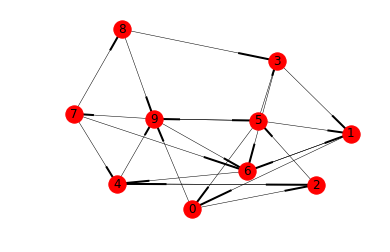

In [4]:
N, p = 10, 0.2
edges = random_graph(N, p)

G = networkx.DiGraph()
G.add_edges_from(edges)
plt.axis('off')
networkx.draw_networkx(G, width=0.5)

Посчитаем его PageRank и изобразим так, чтобы размер вершины был пропорционален ее весу.

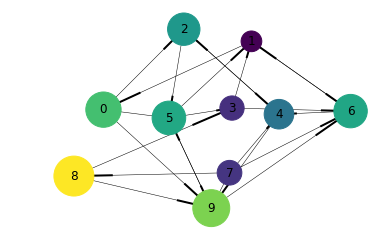

In [5]:
start_distribution = np.ones((1, N)) / N
pr_distribution = page_rank(edges, start_distribution)

size_const = 10 ** 4
plt.axis('off')
networkx.draw_networkx(G, width=0.5, node_size=size_const * pr_distribution, 
                       node_color=pr_distribution)

Как мы уже отмечали выше, эргодическая теорема дает верхнюю оценку на скорость сходимости. Давайте посмотрим, насколько она является точной. Для этого при вычислении PageRank нужно установить флаг return_trace.

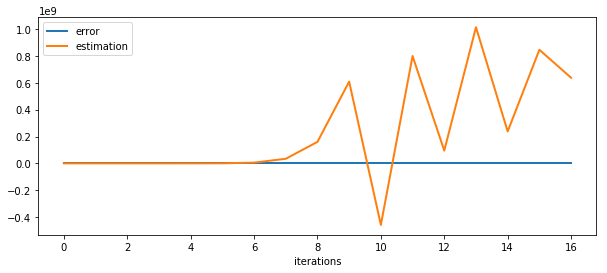

In [6]:
pr_distribution, pr_trace = page_rank(edges, start_distribution, 
                                      return_trace=True)

prob_matrix = create_page_rank_markov_chain(edges)

errors = np.abs(pr_trace - pr_trace[-1]).sum(axis=1)

plt.figure(figsize=(10, 4))
x = np.arange(len(errors))
plt.plot(x, errors, lw=2, label='error')
plt.plot(x, (1 - x) ** 10 * (prob_matrix.max() - prob_matrix.min()), 
         lw=2, label='estimation')
plt.legend()
plt.xlabel('iterations')
plt.show()

# Part 2 (15%)

В этой части вам предстоит построить реальный веб-граф и посчитать его PageRank. Ниже определены вспомогательные функции.

In [7]:
def load_links(url, sleep_time=1, attempts=5, timeout=20):
    ''' Загружает страницу по ссылке url и выдает список ссылок, 
    на которые ссылается данная страница.
        url --- string, адрес страницы в интернете;
        sleep_time --- задержка перед загрузкой страницы;
        timeout --- время ожидания загрузки страницы;
        attempts --- число попыток загрузки страницы. 
        Попытка считается неудачной, если выбрасывается исключение.
    
        В случае, если за attempts попыток не удалось загрузить страницу,
        то последнее исключение пробрасывается дальше.
    '''
    
    sleep(sleep_time)
    parsed_url = urlparse(url)
    links = []

    # Попытки загрузить страницу
    for i in range(attempts):
        try:
            # Ловить исключения только из urlopen может быть недостаточно. 
            # Он может выдавать какой-то бред вместо исключения, 
            # из-за которого исключение сгенерирует BeautifulSoup
            soup = BeautifulSoup(urlopen(url, timeout=timeout), 'lxml')
            break
            
        except Exception as e:
            print(e)
            if i == attempts - 1:
                raise e

    for tag_a in soup('a'):  # Посмотр всех ссылочных тегов
        if 'href' in tag_a.attrs:
            link = list(urlparse(tag_a['href']))
            
            # Если ссылка является относительной,
            # то ее нужно перевести в абсолютную
            if link[0] == '': link[0] = parsed_url.scheme
            if link[1] == '': link[1] = parsed_url.netloc
            
            links.append(urlunparse(link))
            
    return links


def get_site(url):
    ''' По ссылке url возвращает адрес сайта. '''
    
    return urlparse(url).netloc

Код ниже загружает $N$ веб-страниц, начиная с некоторой стартовой страницы и переходя по ссылкам. Загрузка происходит методом обхода в ширину. Все собранные урлы страниц хранятся в urls. В links хранится список ссылок с одной страницы на другую. Особенность кода такова, что в urls хранятся все встреченные урлы, которых может быть сильно больше $N$. Аналогично, в links ребра могут ссылаться на страницы с номером больше $N$. Однако, все ребра из links начинаются только в первых $N$ страницах. Таким образом, для построения веб-графа нужно удалить все, что связано с вершинами, которые не входят в первые $N$.

Это очень примерный шаблон, к тому же не оптимальный. Можете вообще его не использовать и написать свое.

In [8]:
def check_site(urls):
    site = get_site(urls[0])
    links = []

    N = 10
    for i in range(N):
        try:
            # Загружаем страницу по урлу и извлекаем из него все ссылки
            # Не выставляйте sleep_time слишком маленьким, 
            # а то еще забанят где-нибудь
            links_from_url = load_links(urls[i], sleep_time=0.5)
            # Если мы хотим переходить по ссылкам только определенного сайта
            links_from_url = list(filter(lambda x: get_site(x) == site, 
                                         links_from_url))

            # Добавляем соответствующие вершины и ребра в веб-граф
            for j in range(len(links_from_url)):
                # Такая ссылка уже есть
                if links_from_url[j] in urls:
                    links.append((i, urls.index(links_from_url[j])))

                # Новая ссылка
                else:
                    links.append((i, len(urls)))
                    urls.append(links_from_url[j])

        except:
            pass  # Не загрузилась с 5 попытки, ну и ладно
    
    return links, urls

In [9]:
links, urls = check_site(['http://www.fml31.ru/'])

Теперь выберите какой-нибудь сайт с небольшим количеством страниц (не более 1000). Таким сайтом может быть, например, сайт <a href=http://yandexdataschool.ru>Школы анализа данных</a>, сайт магазина, больницы. Однако, советуем не выбирать сайты типа kremlin.ru, мало ли что.

Постройте полный веб-граф для этого сайта и визуализируйте его. При отрисовке выставляйте width не более 0.1, иначе получится ужасно некрасиво.

Посчитайте PageRank для этого веб-графа. Визуализируйте данный веб-граф, сделав размер вершин пропорционально весу PageRank (см. пример в части 1). Постройте гистограмму весов. Что можно сказать про скорость сходимости?

Выделите небольшое количество (15-20) страниц с наибольшим весом и изобразите граф, индуцированный на этом множестве вершин. Что это за страницы? Почему именно они имеют большой вес?

Как меняется вес PageRank для страниц в зависимости от начального приближения в случае, если не доводить итерационный процесс вычисления до сходимости? Какие выводы о поведении пользователя отсюда можно сделать?

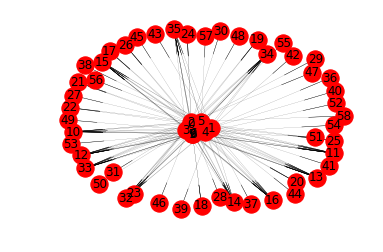

In [10]:
def build_webgraph(links):
    G = networkx.DiGraph()
    G.add_edges_from(links)
    plt.axis('off')
    networkx.draw_networkx(G, width=0.1)
    return G
    
G = build_webgraph(links)

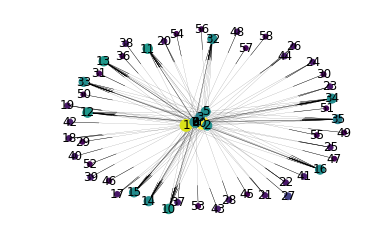

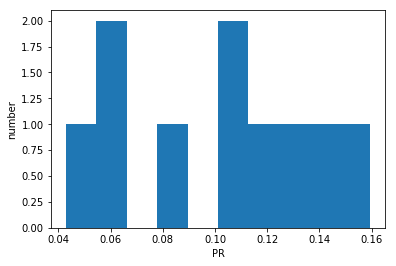

In [11]:
def draw_pr(links):
    N = np.asarray(links).max() + 1

    start_distribution = np.ones((1, N)) / N
    pr_distribution = page_rank(links, start_distribution)

    size_const = 10 ** 10
    plt.axis('off')
    networkx.draw_networkx(G, width=0.1, node_size=size_const * pr_distribution, 
                           node_color=pr_distribution)

draw_pr(links)

plt.show()

plt.hist(pr_distribution)
plt.xlabel('PR')
plt.ylabel('number')
plt.show()

### Страницы с максимальным PR

3 http://www.fml31.ru/proektnaa-i-issledovatelskaa-deatelnost
7 http://www.fml31.ru/kino
8 http://www.fml31.ru/kino/fml-kino-2016
5 http://www.fml31.ru/about
1 http://www.fml31.ru/fond
4 http://www.fml31.ru/arhiv-2017/news12-13/vremacitat-2015
6 http://www.fml31.ru/about/300-voprosov
0 http://www.fml31.ru/
2 http://www.fml31.ru/anonce-2017
9 http://www.fml31.ru/kino/fml-kino-2015


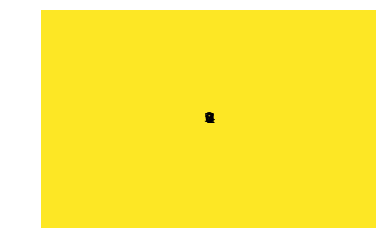

In [12]:
best = np.argsort(pr_distribution)[-10:]
best_pr = np.sort(pr_distribution)[-10:]

for i in best:
    print(i, urls[i])
    
N = np.asarray(links).max() + 1

start_distribution = np.ones((1, N)) / N
pr_distribution = page_rank(links, start_distribution)

size_const = 10 ** 10
plt.axis('off')
networkx.draw_networkx(G.subgraph(best), width=0.1, node_size=size_const * best_pr, 
                       node_color=best_pr)